# "I dream of painting and then I paint my dream." - Vincent Van Gogh
<img src="https://www.vincentvangogh.org/images/paintings/self-portrait-with-straw-hat.jpg" width="400px" height="200px"/>

# Introduction
Creation of art is among the highest form of expression of human mind and imagination. The ability of communicating imagination sets us apart from all other beings. Painting, being an expression of visual language, have attracted and connected the brilliant human minds since the dawn of civilization - from early drawings on walls of caves to paper or glass paintings of modern times, from charcoals in prehistoric times to water, oil, or pastel colors of today. We have travelled a long way, and have finally reached a stage where not only humans but computers, another brilliant creation of human minds, is creating paintings.

For an enthusiast of arts, identifying the paintings of her favorite artists is not that difficult, given years of careful practice and research. Given a painting, she can easily identify if it was painted by a painter she is passionate about. But can a computer do the same? Can a machine without emotions identify who the genius is behind a mindblowing painting?

In this kernel, let us try to explore that direction, using techniques of deep learning.

#### Special thanks to [Icaro](https://www.kaggle.com/ikarus777) for sharing this wonderful dataset with us!

# Objective:
Develop an algorithm which will identify the artist when provided with a painting, with state of the art precision.

# My high-level approach to solution:
## Data processing:
* There are paintings of 50 artists in the dataset. However only 11 artists have more than 200 paintings available here.
* To reduce computation and better training, I decided to use the paintings of these 11 artists only.
* Since this is an imbalanced datset (Van Gogh has 877 paintings whereas Marc Chagall has only 239), `class_weight` is important. Infact, it improved model performance substantially.
* I used Keras `ImageDataGenerator` for data augmentation. This is not a traditional object detection problem, hence the augmentation approch should be used very carefully.
* I couldn't experiment in detail, but so far `zoom_range` worked well.

## Modelling and Training:
* Use convolutional neural network based approach, with a pre-defined architecture as baseline.
* I tried multiple architectures, however `ResNet50` worked well so far.
* Pretrained weights on `imagenet` helped the model train better.
* The objective is to identify artist and not objects in the images. So the model should understand the style of the image better rather than the final output. Hence, training of shallow layers is more important than the deeper layers.
* The above statement is based on my understanding of the problem and experiments and observations.
* Training the model for more iterations might improve the performance, at the cost of computation resource.

## Predictions:
* <b>The final model could identify the artists with an approximate accuracy of 99% on training set and 85% on cross-validation set.</b>

# Let's implement "DeepArtist" :)

## Read data

In [54]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

In [55]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [56]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import os
print(os.listdir('/content/drive/My Drive/input'))


['images', 'resized', 'artists - artists.csv']


In [58]:
artists = pd.read_csv('/content/drive/My Drive/input/artists - artists.csv')
artists.shape

(51, 8)

## Data Processing

In [59]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0        Vincent van Gogh        877      0.427784
1             Edgar Degas        702      0.534425
2           Pablo Picasso        439      0.854594
3   Pierre-Auguste Renoir        336      1.116567
4          Albrecht Dürer        328      1.143801
5            Paul Gauguin        311      1.206324
6          Francisco Goya        291      1.289233
7               Rembrandt        262      1.431934
8           Alfred Sisley        259      1.448520
9                  Titian        255      1.471242
10           Marc Chagall        239      1.569735
11            Omar Elalem        203      1.848112

In [60]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.42778411250475107,
 1: 0.5344254510921178,
 2: 0.8545937737281701,
 3: 1.1165674603174602,
 4: 1.14380081300813,
 5: 1.2063236870310825,
 6: 1.2892325315005728,
 7: 1.4319338422391859,
 8: 1.4485199485199485,
 9: 1.4712418300653596,
 10: 1.5697350069735008,
 11: 1.848111658456486}

In [61]:
# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [62]:
# Explore images of top artists
images_dir = '/content/drive/My Drive/input/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/My Drive/input/images/images/Vincent_van_Gogh
Found --> /content/drive/My Drive/input/images/images/Edgar_Degas
Found --> /content/drive/My Drive/input/images/images/Pablo_Picasso
Found --> /content/drive/My Drive/input/images/images/Pierre-Auguste_Renoir
Did not find --> /content/drive/My Drive/input/images/images/Albrecht_Dürer
Found --> /content/drive/My Drive/input/images/images/Paul_Gauguin
Found --> /content/drive/My Drive/input/images/images/Francisco_Goya
Found --> /content/drive/My Drive/input/images/images/Rembrandt
Found --> /content/drive/My Drive/input/images/images/Alfred_Sisley
Found --> /content/drive/My Drive/input/images/images/Titian
Found --> /content/drive/My Drive/input/images/images/Marc_Chagall
Found --> /content/drive/My Drive/input/images/images/Omar_Elalem


### Print few random paintings

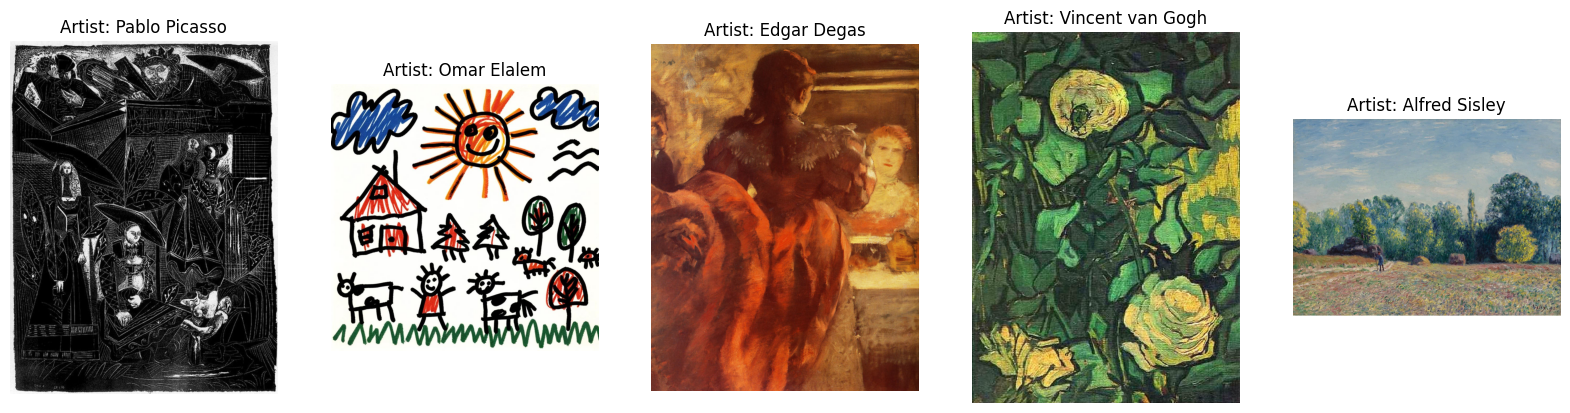

In [63]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Data Augmentation

In [64]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3344 images belonging to 12 classes.
Found 830 images belonging to 12 classes.
Total number of batches = 209 and 51


 **Rotation and Zoom** **Augmentation**

In [65]:
train_datagen_rotation_zoom = ImageDataGenerator(validation_split=0.2,
                                                 rescale=1./255.,
                                                 rotation_range=45,  # Rotates the images up to 45 degrees
                                                 zoom_range=0.2,     # Zooms in/out the images by 20%
                                                 horizontal_flip=True,
                                                 vertical_flip=True,
                                                 shear_range=5)

train_generator_rotation_zoom = train_datagen_rotation_zoom.flow_from_directory(
    directory=images_dir,
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    subset="training",
    shuffle=True,
    classes=artists_top_name.tolist())

valid_generator_rotation_zoom = train_datagen_rotation_zoom.flow_from_directory(
    directory=images_dir,
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    subset="validation",
    shuffle=True,
    classes=artists_top_name.tolist())

# Calculating steps
STEP_SIZE_TRAIN_ROTATION_ZOOM = train_generator_rotation_zoom.n//train_generator_rotation_zoom.batch_size
STEP_SIZE_VALID_ROTATION_ZOOM = valid_generator_rotation_zoom.n//valid_generator_rotation_zoom.batch_size


Found 3344 images belonging to 12 classes.
Found 830 images belonging to 12 classes.


Brightness and Contrast Augmentation

In [66]:
train_datagen_brightness_contrast = ImageDataGenerator(validation_split=0.2,
                                                       rescale=1./255.,
                                                       brightness_range=[0.5,1.5], # Adjusts brightness
                                                       horizontal_flip=True,
                                                       vertical_flip=True,
                                                       shear_range=5)

train_generator_brightness_contrast = train_datagen_brightness_contrast.flow_from_directory(
    directory=images_dir,
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    subset="training",
    shuffle=True,
    classes=artists_top_name.tolist())

valid_generator_brightness_contrast = train_datagen_brightness_contrast.flow_from_directory(
    directory=images_dir,
    class_mode='categorical',
    target_size=train_input_shape[0:2],
    batch_size=batch_size,
    subset="validation",
    shuffle=True,
    classes=artists_top_name.tolist())

# Calculating steps
STEP_SIZE_TRAIN_BRIGHTNESS_CONTRAST = train_generator_brightness_contrast.n//train_generator_brightness_contrast.batch_size
STEP_SIZE_VALID_BRIGHTNESS_CONTRAST = valid_generator_brightness_contrast.n//valid_generator_brightness_contrast.batch_size


Found 3344 images belonging to 12 classes.
Found 830 images belonging to 12 classes.


### Print a random paintings and it's random augmented version

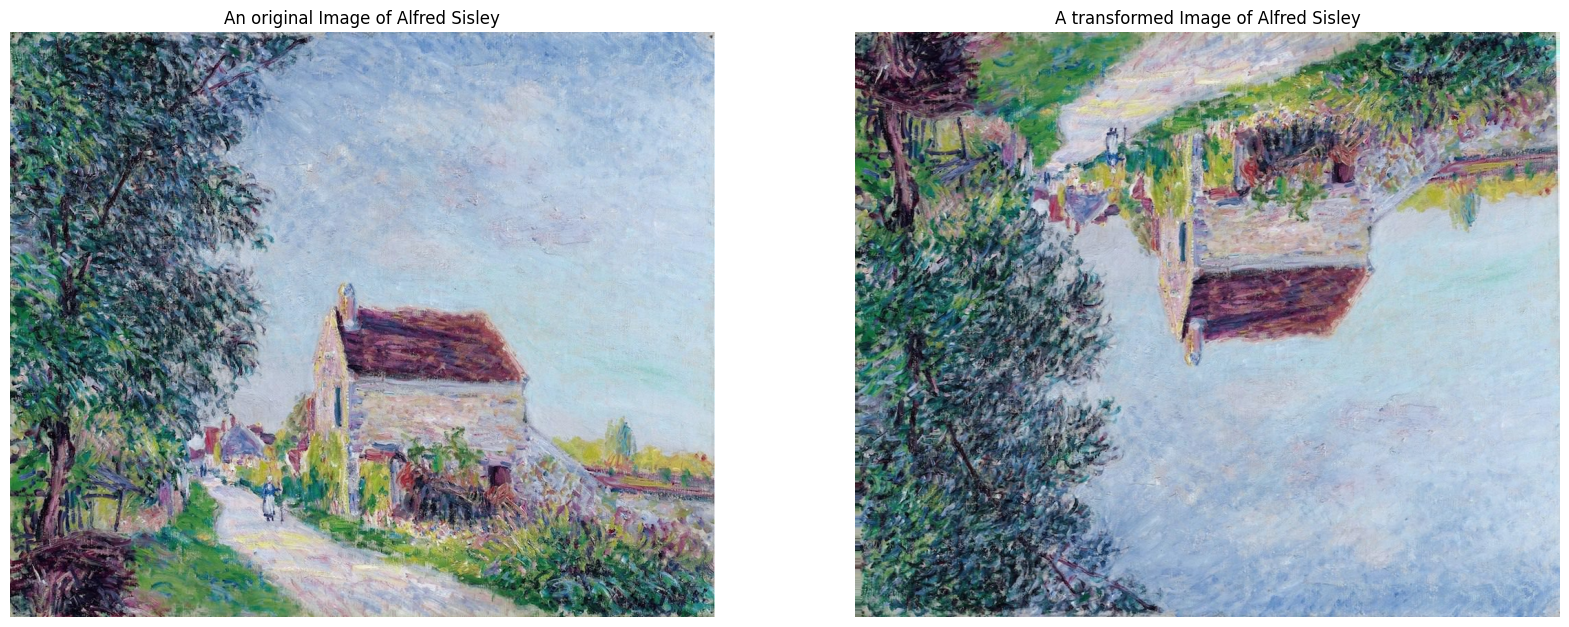

In [67]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

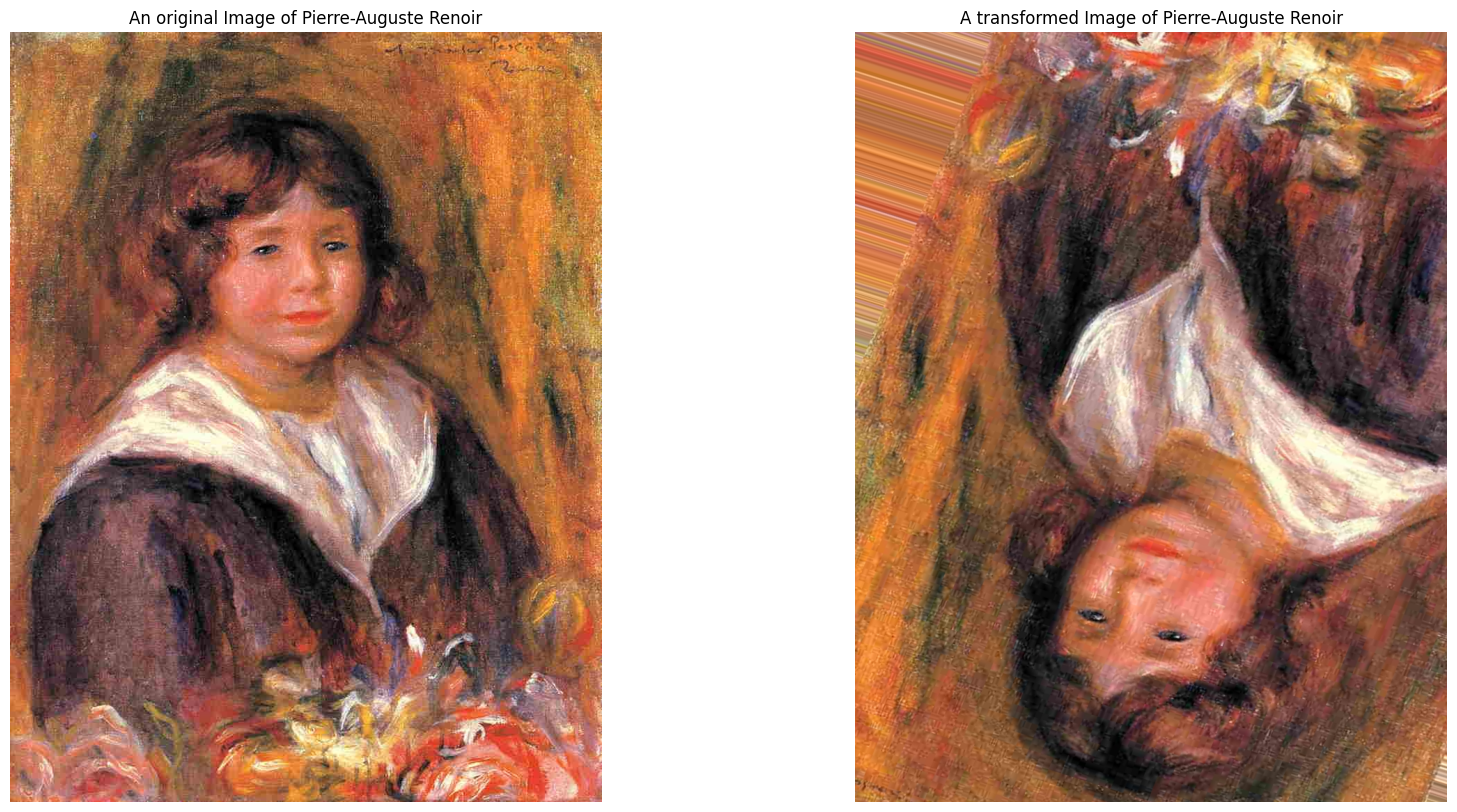

In [68]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image =train_datagen_rotation_zoom.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

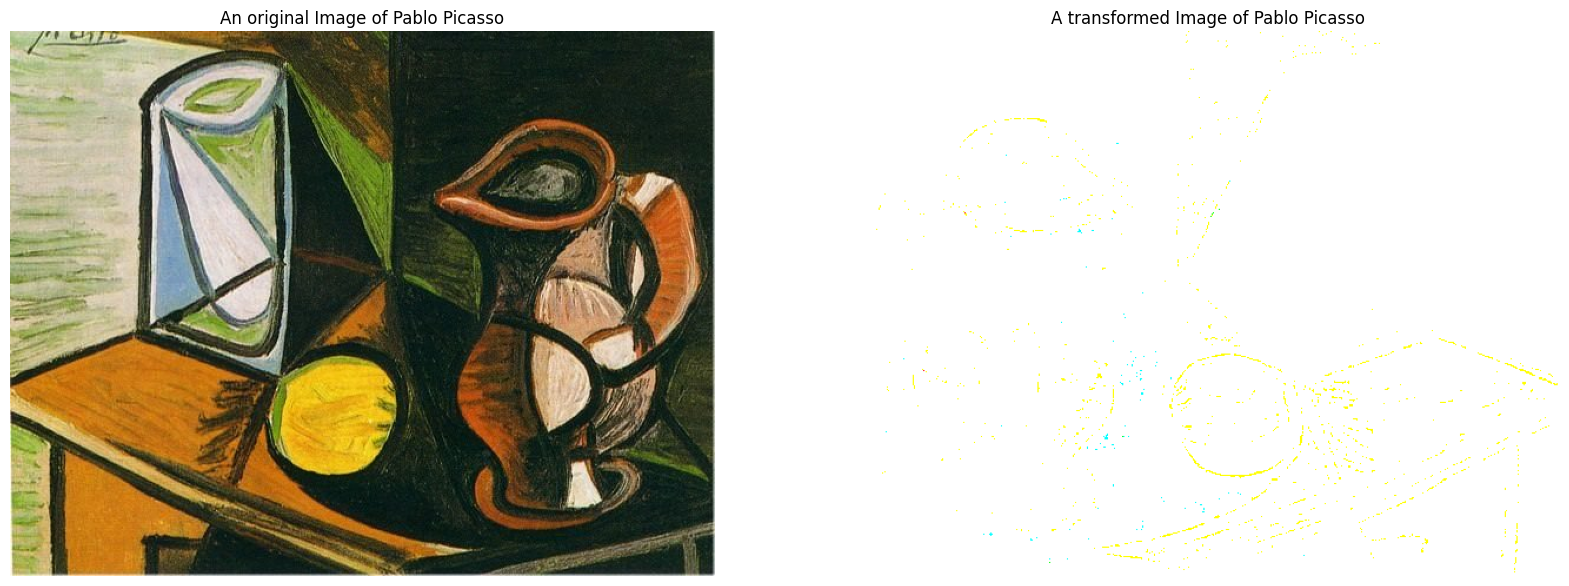

In [69]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen_brightness_contrast.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Build Model

In [70]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [71]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)
model2 = Model(inputs=base_model.input, outputs=output)
model3 = Model(inputs=base_model.input, outputs=output)

In [72]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [73]:
optimizer = Adam(lr=0.0001)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [74]:
optimizer = Adam(lr=0.0001)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [75]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [76]:
print(len(train_generator))

209


In [77]:
print(len(train_generator_rotation_zoom))

209


In [78]:
print(len(train_generator_brightness_contrast))

209


In [ ]:
# Train the model - all layers
history1 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN+1,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10
210/210 [==============================] - 167s 577ms/step - loss: 1.9143 - accuracy: 0.3205 - val_loss: 47.0650 - val_accuracy: 0.0478 - lr: 0.0010
Epoch 2/10
 28/210 [===>..........................] - ETA: 1:23 - loss: 1.7725 - accuracy: 0.3259

In [ ]:
history11 = model2.fit(train_generator_rotation_zoom, steps_per_epoch=STEP_SIZE_TRAIN+1,
                              validation_data=valid_generator_rotation_zoom, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

In [ ]:
history111 = model3.fit(train_generator_brightness_contrast, steps_per_epoch=STEP_SIZE_TRAIN+1,
                              validation_data=valid_generator_brightness_contrast, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

In [ ]:
# Freeze core ResNet layers and train again
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

## Training graph

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['acc'] + history2.history['acc']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_acc'] + history2.history['val_acc']
history['lr'] = history1.history['lr'] + history2.history['lr']

In [ ]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))

    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')

    plt.show()

plot_training(history)

In [ ]:


plot_training(history1.history)

In [ ]:
plot_training(history11.history)

In [ ]:
plot_training(history111.history)

## Evaluate performance

In [ ]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

In [ ]:
# Prediction accuracy on CV data
score = model2.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

In [ ]:
# Prediction accuracy on CV data
score = model3.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

## Confusion Matrix. Look at the style of the artists which the model thinks are almost similar.

In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model2.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [ ]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model3.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

# Evaluate performance by predicting on random images from dataset

In [ ]:
# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model3.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

# This portion is just for fun :) Replace the variable `url` with an image of one of the 11 artists above and run this cell.

In [ ]:
# Predict from web - this is an image of Titian.
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()